<a href="https://colab.research.google.com/github/alexzendersen/metric_learning/blob/main/face_verification_exps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Download

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alexzendersen","key":"a6433b07739f7650ca9ccdbec668e543"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ntl0601/casia-webface

Dataset URL: https://www.kaggle.com/datasets/ntl0601/casia-webface
License(s): unknown


In [ ]:
!unzip -qq -o /content/casia-webface.zip -d /content/dataset

# Dataset preprocessing

In [ ]:
import pickle
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from PIL import Image
from pathlib import Path

import torch
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import colors, pyplot as plt
import random
import cv2
from sklearn.manifold import TSNE

In [ ]:
%matplotlib inline


import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
modes = ['train', 'val', 'test']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
train = Path('dataset/casia-webface')

In [ ]:
d = {}
for dir in train.iterdir():
  d[dir.name] = len(list(dir.iterdir()))

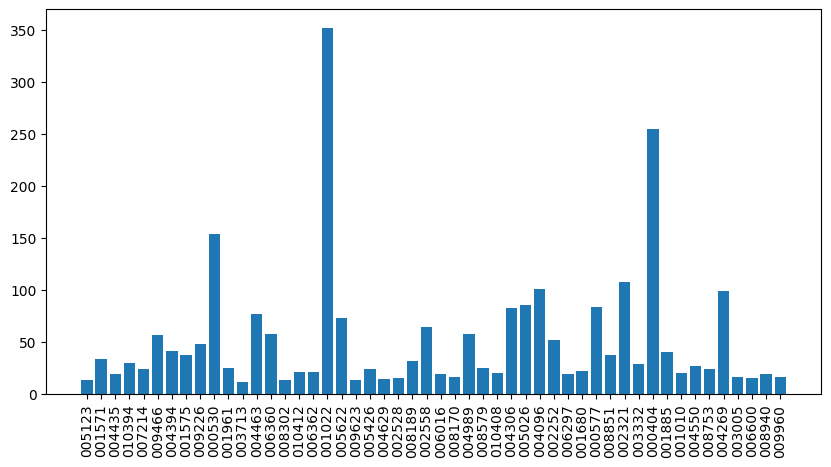

In [ ]:
val, c = list(d.keys()), list(d.values())
plt.figure(figsize = (10, 5))
plt.bar(val[:50], c[:50])
plt.xticks(rotation = 90)
plt.show()

In [ ]:
X_train = []
X_val = []

for v in tqdm(val):
  if d[v] >= 20:
    X_train.extend(train.joinpath(v).rglob("*.jpg"))
  elif 10 <= d[v] < 20:
    X_val.extend(train.joinpath(v).rglob("*.jpg"))

  0%|          | 0/10572 [00:00<?, ?it/s]

In [ ]:
len(X_train), len(X_val)

(441540, 48832)

In [ ]:
def process_image(path):
    img = cv2.imread(path)
    if img is None:
        return np.zeros((224, 224, 3), dtype=np.uint8)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

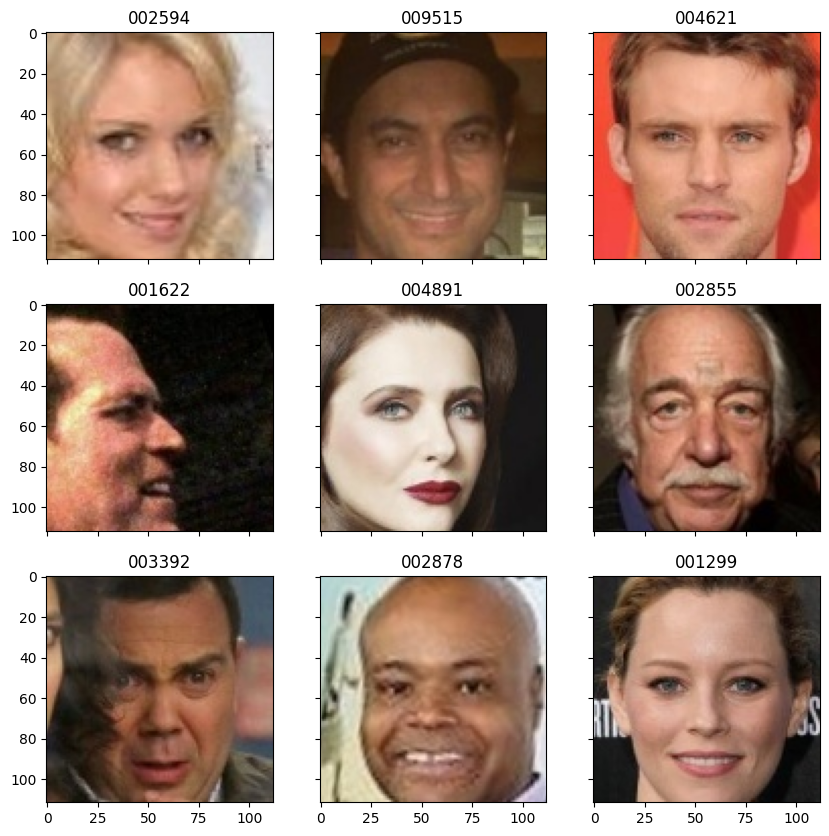

In [ ]:
imgs = random.sample(X_train, 9)
imgs_proc = np.array([process_image(i) for i in imgs])
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (10, 10), sharex = True, sharey = True)
for i, a in enumerate(ax.flatten()):
    a.imshow(imgs_proc[i])
    a.set_title(imgs[i].parent.name)
plt.show()

In [ ]:
# mu = torch.zeros((3,))
# mu_2 = torch.zeros((3,))
# sigma = torch.zeros((3,))
# tr = transforms.ToTensor()
# for p in tqdm(X_train):
#   im = tr(process_image(p))
#   mu += torch.sum(im, dim = [1, 2])
#   mu_2 += torch.sum(im**2, dim = [1, 2])
# mu /= (len(X_train)*112*112)
# sigma = mu_2/(len(X_train)*112*112) - (mu)**2

In [ ]:
# mu, torch.sqrt(sigma)
# (tensor([0.5207, 0.4039, 0.3454]), tensor([0.2806, 0.2433, 0.2346]))

In [ ]:
class CASIADataset(Dataset):
  def __init__(self, files, mode, rescale_size = 224, image_per_class = 16):
    super(CASIADataset, self).__init__()
    self.files = files
    self.labels = torch.tensor([int(self.files[i].parent.name[1:]) for i in range(len(self.files))], dtype = torch.long)
    self.unique_labels = torch.unique(self.labels)
    self.mode = mode
    self.image_per_class = image_per_class

    self.label_class = {label.item(): [] for label in self.unique_labels}

    for file, label in tqdm(zip(self.files, self.labels), total = len(files)):
      self.label_class[label.item()].append(file)

    if self.mode not in modes:
      print(f"{self.mode} is not correct; correct modes: {modes}")
      raise NameError

    self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5207, 0.4039, 0.3454], [0.1651, 0.1319, 0.1170]),
    ])

    self.augment = transforms.Compose([
        transforms.RandomRotation(degrees=20),
        transforms.RandomHorizontalFlip(p = 0.5)
    ])

  def __len__(self):
    return len(self.unique_labels)

  def __getitem__(self, index):
    image_label = self.unique_labels[index].item()
    files = self.label_class[image_label]

    selected_files = random.sample(files, self.image_per_class)

    images = []
    for file in selected_files:
        loaded = self._load_sample(file)
        loaded = self.transform(loaded)
        if self.mode == 'train':
            loaded = self.augment(loaded)
        images.append(loaded)

    return torch.full((len(images),), fill_value=image_label), torch.stack(images)

  def _load_sample(self, file):
    with Image.open(file) as img:
        return np.array(img.convert("RGB"))

In [ ]:
train_dataset = CASIADataset(X_train, 'train', image_per_class = 12)
val_dataset = CASIADataset(X_val, 'val', image_per_class = 8)

  0%|          | 0/441540 [00:00<?, ?it/s]

  0%|          | 0/48832 [00:00<?, ?it/s]

# Utils

In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        distance = F.pairwise_distance(output1, output2)
        loss = label * distance.pow(2) + (1 - label) * F.relu(self.margin - distance).pow(2)
        return loss

In [ ]:
def create_pairs(embeddings, labels, margin=1, mode='semi-hard', d=128):
    unique_labels = torch.unique(labels)
    pairs = []
    avg_pos_dist = 0
    avg_neg_dist = 0
    iters = 0

    for label in unique_labels:
        label = label.item()
        pos_inds = torch.where(labels == label)[0]
        neg_inds = torch.where(labels != label)[0]

        if len(pos_inds) < 2 or len(neg_inds) == 0:
            continue

        anchor_idx = pos_inds[torch.randint(0, len(pos_inds), (1,))]
        pos_inds = pos_inds[pos_inds != anchor_idx]

        if len(pos_inds) == 0:
            continue

        anchor_embed = embeddings[anchor_idx]

        if mode == 'random':
            pos_idx = pos_inds[torch.randint(0, len(pos_inds), (1,))]
            pos_embed = embeddings[pos_idx]
            dist_pos = torch.norm(anchor_embed - pos_embed)
            pairs.append((anchor_embed, pos_embed, 1))
            avg_pos_dist += dist_pos

            neg_idx = neg_inds[torch.randint(0, len(neg_inds), (1,))]
            neg_embed = embeddings[neg_idx]
            dist_neg = torch.norm(anchor_embed - neg_embed)
            pairs.append((anchor_embed, neg_embed, 0))
            avg_neg_dist += dist_neg

        elif mode == 'semi-hard':
            pos_dists = torch.norm(embeddings[pos_inds] - anchor_embed, dim=1)
            pos_idx = pos_inds[torch.argmax(pos_dists)]
            pos_embed = embeddings[pos_idx]
            dist_pos = torch.norm(anchor_embed - pos_embed)
            avg_pos_dist += dist_pos
            pairs.append((anchor_embed, pos_embed, 1))

            neg_dists = torch.norm(embeddings[neg_inds] - anchor_embed, dim=1)
            mask = (neg_dists > dist_pos) & (neg_dists < dist_pos + margin)
            valid_neg_inds = neg_inds[mask]
            if len(valid_neg_inds) > 0:
                neg_idx = valid_neg_inds[torch.randint(0, len(valid_neg_inds), (1,))]
            else:
                neg_idx = neg_inds[torch.argmin(neg_dists)]
            neg_embed = embeddings[neg_idx]
            dist_neg = torch.norm(anchor_embed - neg_embed)
            avg_neg_dist += dist_neg
            pairs.append((anchor_embed, neg_embed, 0))

        elif mode == 'hard':
            pos_dists = torch.norm(embeddings[pos_inds] - anchor_embed, dim=1)
            pos_idx = pos_inds[torch.argmax(pos_dists)]
            pos_embed = embeddings[pos_idx]
            dist_pos = torch.norm(anchor_embed - pos_embed)
            avg_pos_dist += dist_pos
            pairs.append((anchor_embed, pos_embed, 1))

            neg_dists = torch.norm(embeddings[neg_inds] - anchor_embed, dim=1)
            neg_idx = neg_inds[torch.argmin(neg_dists)]
            neg_embed = embeddings[neg_idx]
            dist_neg = torch.norm(anchor_embed - neg_embed)
            avg_neg_dist += dist_neg
            pairs.append((anchor_embed, neg_embed, 0))

        elif mode == 'distance-weighted':
            pos_dists = torch.norm(embeddings[pos_inds] - anchor_embed, dim=1)
            pos_idx = pos_inds[torch.argmax(pos_dists)]
            pos_embed = embeddings[pos_idx]
            dist_pos = torch.norm(anchor_embed - pos_embed)
            avg_pos_dist += dist_pos
            pairs.append((anchor_embed, pos_embed, 1))

            neg_embeds = embeddings[neg_inds]
            dists = torch.norm(neg_embeds - anchor_embed, dim=1).clamp(min=1e-6)
            log_probs = (d - 2) * torch.log(dists) - ((d - 3) / 2) * dists.pow(2)
            probs = torch.softmax(log_probs, dim=0)

            if probs.sum() > 0:
                neg_idx = neg_inds[torch.multinomial(probs, 1)]
            else:
                neg_idx = neg_inds[torch.argmin(dists)]

            neg_embed = embeddings[neg_idx]
            dist_neg = torch.norm(anchor_embed - neg_embed)
            avg_neg_dist += dist_neg
            pairs.append((anchor_embed, neg_embed, 0))

        else:
            raise ValueError(f"Unknown mode: {mode}")

        iters += 1

    if iters == 0:
        return pairs, 0, 0

    return pairs, avg_pos_dist / iters, avg_neg_dist / iters


In [ ]:
def create_triplets(embeddings, labels, margin=1, num_triplets_for_one=5, mode='semi-hard', d=128):
    unique_labels = torch.unique(labels)
    triplets = []
    avg_pos_dist = 0
    avg_neg_dist = 0
    iters = 0

    for label in unique_labels:
        anchor_label = label.item()

        positive_inds = torch.where(labels == anchor_label)[0]
        negative_inds = torch.where(labels != anchor_label)[0]

        if len(positive_inds) < 2 or len(negative_inds) == 0:
            continue

        anchor_index = positive_inds[torch.randint(0, len(positive_inds), (1,))]
        positive_inds = positive_inds[positive_inds != anchor_index]

        if len(positive_inds) == 0:
            continue

        anchor_embedding = embeddings[anchor_index]

        if mode == 'random':
            pos_samples = positive_inds[torch.randint(0, len(positive_inds), (num_triplets_for_one,))]
            neg_samples = negative_inds[torch.randint(0, len(negative_inds), (num_triplets_for_one,))]

        elif mode == 'semi-hard':
            pos_dists_all = torch.norm(embeddings[positive_inds] - anchor_embedding, dim=1)
            top_pos_indices = torch.topk(pos_dists_all, k=min(num_triplets_for_one, len(pos_dists_all))).indices
            positive_inds = positive_inds[top_pos_indices]

            pos_dists = torch.cdist(anchor_embedding, embeddings[positive_inds])
            avg_pos_dist += pos_dists.sum()
            neg_dists = torch.cdist(anchor_embedding, embeddings[negative_inds])

            valid_negatives = []
            for pos_ind, pos_dist in zip(positive_inds, pos_dists[0]):
                mask = (pos_dist < neg_dists[0]) & (pos_dist + margin > neg_dists[0])
                valid_neg_inds = negative_inds[mask]
                if len(valid_neg_inds) > 0:
                    r_i = torch.randint(0, len(valid_neg_inds), (1,))
                    valid_negatives.append(valid_neg_inds[r_i].item())
                    avg_neg_dist += torch.linalg.norm(embeddings[valid_neg_inds[r_i]] - anchor_embedding)

            if not valid_negatives:
                continue

            pos_samples = positive_inds[:len(valid_negatives)]
            neg_samples = torch.tensor(valid_negatives)

        elif mode == 'distance-weighted':
            pos_dists_all = torch.norm(embeddings[positive_inds] - anchor_embedding, dim=1)
            top_pos_indices = torch.topk(pos_dists_all, k=min(num_triplets_for_one, len(pos_dists_all))).indices
            positive_inds = positive_inds[top_pos_indices]

            pos_dists = torch.norm(embeddings[positive_inds] - anchor_embedding, dim=1)
            avg_pos_dist += pos_dists.sum()

            neg_embeds = embeddings[negative_inds]
            dists = torch.norm(neg_embeds - anchor_embedding, dim=1).clamp(min=1e-6)  # avoid log(0)

            # Distance-weighted sampling formula (Wu et al.)
            log_probs = (d - 2) * torch.log(dists) - ((d - 3) / 2) * dists.pow(2)
            probs = torch.softmax(log_probs, dim=0)

            if len(probs) < num_triplets_for_one:
                continue

            idx = torch.multinomial(probs, num_samples=num_triplets_for_one, replacement=False)
            neg_samples = negative_inds[idx]
            pos_samples = positive_inds

            avg_neg_dist += torch.norm(embeddings[neg_samples] - anchor_embedding, dim=1).sum()

        elif mode == 'hard':
            pos_dists_all = torch.norm(embeddings[positive_inds] - anchor_embedding, dim=1)
            top_pos_indices = torch.topk(pos_dists_all, k=min(num_triplets_for_one, len(pos_dists_all))).indices
            positive_inds = positive_inds[top_pos_indices]

            neg_dists_all = torch.norm(embeddings[negative_inds] - anchor_embedding, dim=1)
            top_neg_indices = torch.topk(neg_dists_all, k=min(num_triplets_for_one, len(neg_dists_all)), largest=False).indices
            negative_inds = negative_inds[top_neg_indices]

            pos_samples = positive_inds
            neg_samples = negative_inds

            avg_pos_dist += torch.norm(embeddings[pos_samples] - anchor_embedding, dim=1).sum()
            avg_neg_dist += torch.norm(embeddings[neg_samples] - anchor_embedding, dim=1).sum()

        else:
            raise ValueError(f"Unknown mode: {mode}")

        for pos, neg in zip(embeddings[pos_samples], embeddings[neg_samples]):
            triplets.append((
                anchor_embedding,
                pos.unsqueeze(0),
                neg.unsqueeze(0)
            ))

        iters += 1

    if iters == 0:
        return triplets, 0, 0

    return triplets, avg_pos_dist / (num_triplets_for_one * iters), avg_neg_dist / (num_triplets_for_one * iters)

In [ ]:
def accuracy_val_far(embeddings, labels, thresholds, num_samples=30000):

  anc_inds = torch.randint(0, len(labels), (num_samples,))

  pos_mask = (labels.unsqueeze(0) == labels[anc_inds].unsqueeze(1))
  pos_mask[torch.arange(num_samples), anc_inds] = False
  pos_inds = torch.multinomial(pos_mask.float(), 1).squeeze(1)

  neg_mask = (labels.unsqueeze(0) != labels[anc_inds].unsqueeze(1))
  neg_inds = torch.multinomial(neg_mask.float(), 1).squeeze(1)

  acc_list, val_list, far_list = [], [], []

  correct = 0

  pos_norms = torch.linalg.norm(embeddings[anc_inds] - embeddings[pos_inds], dim = 1)
  neg_norms = torch.linalg.norm(embeddings[anc_inds] - embeddings[neg_inds], dim = 1)
  for t in thresholds:
    fa = 0
    ta = 0

    mask_1 = (pos_norms < t)
    mask_2 = (neg_norms < t)

    ta += torch.sum(mask_1)
    fa += torch.sum(mask_2)

    acc_list.append((ta + num_samples - fa) / (2*num_samples))
    val_list.append(ta / num_samples)
    far_list.append(fa / num_samples)

  val_list = np.array(val_list)
  far_list = np.array(far_list)

  VAL = np.max(val_list[far_list < 1e-2])

  return acc_list, VAL

In [ ]:
def visualize_tsne(embeddings, labels):
    tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, init='pca', learning_rate='auto')
    reduced = tsne.fit_transform(embeddings)
    return reduced

# Training functions

In [40]:
def fit_epoch(model, train_loader, criterion, optimizer, margin, mode = 'semi-hard', d = 128, images_size = 224, scheduler = None):
    model.train()
    total_loss = 0.0
    total_triplets = 0
    total_acc = 0
    iters = 0
    avg_pos = 0
    avg_neg = 0
    for labels, inputs in tqdm(train_loader):
        inputs = inputs.to(device).view(-1, 3, images_size, images_size)
        labels = labels.view(-1)

        optimizer.zero_grad()

        outputs = model(inputs).cpu()
        triplets, avg_pos_dist, avg_neg_dist = create_triplets(outputs, labels.cpu(), margin, mode = mode, d = d)
        avg_pos += avg_pos_dist
        avg_neg += avg_neg_dist
        losses = [criterion(*triplet) for triplet in triplets]
        batch_loss = torch.stack(losses).mean()
        batch_loss.backward()
        optimizer.step()
        if scheduler:
          scheduler.step()
        total_loss += batch_loss.item()
        total_triplets += len(triplets)
        iters += 1
        torch.cuda.empty_cache()

    epoch_loss = total_loss / total_triplets if total_triplets > 0 else 0.0
    return total_loss / iters, avg_pos/iters, avg_neg/iters

In [41]:
def eval_epoch(model, val_loader, criterion, margin, mode = 'semi-hard', d = 128, images_size = 224, epoch = 1, freq = 1):
    model.eval()
    total_loss = 0
    total_acc = []
    total_triplets = 0
    thresholds = np.linspace(0, 2, 200)
    iters = 0
    avg_pos = 0
    avg_neg = 0
    all_out = []
    all_labl = []
    for labels, inputs in tqdm(val_loader):
        accs_loc = []
        inputs = inputs.to(device).view(-1, 3, images_size, images_size)
        labels = labels.to(device).view(-1)
        with torch.no_grad():
            outputs = model(inputs)
            all_out.extend(outputs.cpu())
            all_labl.extend(labels.cpu())
            losses = []
            triplets, avg_pos_dist, avg_neg_dist = create_triplets(outputs.cpu(), labels.cpu(), margin, mode = mode, d = d)
            avg_pos += avg_pos_dist
            avg_neg += avg_neg_dist
            losses = [criterion(*triplet) for triplet in triplets]
            total_loss += torch.mean(torch.stack(losses))
            if iters == 0:
              total_acc = accs_loc.copy()
            else:
              total_acc = total_acc + accs_loc
            total_triplets += len(triplets)
            iters += 1
    scatter = visualize_tsne(np.array(all_out)[:300], all_labl[:300])
    acc_list, VAL = accuracy_val_far(torch.stack(all_out), torch.tensor(all_labl), np.linspace(0, 2, 201))
    return total_loss / iters, acc_list, VAL, avg_pos/iters, avg_neg/iters, scatter, all_labl[:300]

In [42]:
import os

def train(model, epochs, criterion, batch_size, loss_margin=0.3, beta=0.3, gamma=0.1, n=3, triplet_margin=0.3, mode='semi-hard',
          d=128, images_size=224, save=False, tsne_freq=10, checkpoint_freq=10):

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    history = []

    # Создание основной директории логов
    log_dir = f"logs/{model.__class__.__name__}_{mode}_BS_{batch_size}"
    os.makedirs(log_dir, exist_ok=True)

    log_template = """
    Epoch {ep:03d}, mode = {mode}
    train_loss: {t_loss:.4f} train_avg_pos: {t_pos:0.4f} train_avg_neg: {t_neg:0.4f}
    val_loss: {v_loss:.4f} val_avg_pos: {v_pos:0.4f} val_avg_neg: {v_neg:0.4f}
    """
    acc_template = "\nmax acc = {acc:.4f} with threshold {tr:.4f}"
    val_template = "\nmax val = {val:.4f}"

    # criterion = newLoss(beta=beta, n=n, margin=loss_margin, gamma=gamma)
    opt = torch.optim.Adam([{'params': model.parameters()}], lr=1e-2)

    scheduler = OneCycleLR(
        opt,
        max_lr=0.1,
        total_steps=len(train_loader) * epochs,
        pct_start=0.3,
        anneal_strategy='cos',
        div_factor=25,
        final_div_factor=1e4
    )

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, avg_pos_train, avg_neg_train = fit_epoch(
                model=model,
                train_loader=train_loader,
                criterion=criterion,
                optimizer=opt,
                margin=triplet_margin,
                mode=mode,
                d=d,
                images_size=images_size,
                scheduler=scheduler
            )

            val_loss, v_acc, VAL, avg_pos_val, avg_neg_val, scatter, lbls = eval_epoch(
                model=model,
                val_loader=val_loader,
                criterion=criterion,
                margin=triplet_margin,
                mode=mode,
                d=d,
                images_size=images_size,
                epoch=epoch + 1,
                freq=tsne_freq
            )

            lr = opt.param_groups[0]['lr']
            epoch_data = {
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'val_loss': val_loss.item(),
                'max_val_acc': np.max(v_acc),
                'best_acc_threshold': np.linspace(0, 2, 201)[np.argmax(v_acc)],
                'VAL': VAL,
                'lr': lr
            }
            history.append(epoch_data)

            if (epoch + 1) % tsne_freq == 0:
                tsne_dir = os.path.join(log_dir, f"epoch_{epoch+1}")
                os.makedirs(tsne_dir, exist_ok=True)

                fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
                ax1.set_title("Val acc")
                ax1.plot(np.linspace(0, 2, 201), v_acc)
                ax2.set_title(f"TSNE on epoch {epoch + 1}")
                scatter = np.array(scatter)
                lbls = np.array(lbls)
                ax2.scatter(scatter[:, 0], scatter[:, 1], c=lbls, s=10, cmap='tab20', alpha=0.7)
                plt.tight_layout()
                tsne_img_path = os.path.join(tsne_dir, f"tsne_epoch_{epoch+1}.png")
                plt.savefig(tsne_img_path)
                plt.close()

                tsne_data_path = os.path.join(tsne_dir, f"tsne_data_epoch_{epoch+1}.npz")
                np.savez(tsne_data_path, scatter=scatter, labels=lbls)

            tqdm.write(acc_template.format(acc=np.max(v_acc), tr=np.linspace(0, 2, 201)[np.argmax(v_acc)]))
            tqdm.write(val_template.format(val=VAL))
            tqdm.write(log_template.format(ep=epoch + 1, mode=mode,
                                           t_loss=train_loss, v_loss=val_loss.item(),
                                           t_pos=avg_pos_train, t_neg=avg_neg_train,
                                           v_pos=avg_pos_val, v_neg=avg_neg_val))
            pbar_outer.update(1)

            if (epoch + 1) % checkpoint_freq == 0:
                model_path = os.path.join(log_dir, f"model_epoch_{epoch+1}.pth")
                torch.save(model.state_dict(), model_path)

                df = pd.DataFrame(history)
                csv_path = os.path.join(log_dir, f"history.csv")
                df.to_csv(csv_path, index=False)

            torch.cuda.empty_cache()

    if save:
        model_path = os.path.join(log_dir, f"final_model.pth")
        torch.save(model.state_dict(), model_path)

        df = pd.DataFrame(history)
        csv_path = os.path.join(log_dir, f"history.csv")
        df.to_csv(csv_path, index=False)

    return history


In [ ]:
def fit_epoch_contrastive(model, train_loader, criterion, optimizer, margin, mode='semi-hard', d=128, images_size=224, scheduler=None):
    model.train()
    total_loss = 0.0
    total_pairs = 0
    avg_pos = 0
    avg_neg = 0

    iters = 0

    for labels, inputs in tqdm(train_loader):
        inputs = inputs.to(device).view(-1, 3, images_size, images_size)
        labels = labels.view(-1)

        optimizer.zero_grad()

        outputs = model(inputs).cpu()
        pairs, avg_pos_dist, avg_neg_dist = create_pairs(outputs, labels.cpu(), margin, mode=mode, d=d)
        avg_pos += avg_pos_dist
        avg_neg += avg_neg_dist

        losses = [criterion(pair[0], pair[1], torch.tensor([pair[2]], dtype=torch.float)) for pair in pairs]
        batch_loss = torch.stack(losses).mean()
        batch_loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
        total_loss += batch_loss.item()
        total_pairs += len(pairs)
        torch.cuda.empty_cache()
        iters += 1
    epoch_loss = total_loss / iters
    return epoch_loss, avg_pos / iters, avg_neg / iters


In [ ]:
def eval_epoch_contrastive(model, val_loader, criterion, margin, mode='semi-hard', d=128, images_size=224, epoch=1, freq=1):
    model.eval()
    total_loss = 0
    total_pairs = 0
    avg_pos = 0
    avg_neg = 0
    all_out = []
    all_labl = []
    iters = 0

    for labels, inputs in tqdm(val_loader):
        inputs = inputs.to(device).view(-1, 3, images_size, images_size)
        labels = labels.to(device).view(-1)
        with torch.no_grad():
            outputs = model(inputs)
            all_out.extend(outputs.cpu())
            all_labl.extend(labels.cpu())

            pairs, avg_pos_dist, avg_neg_dist = create_pairs(outputs.cpu(), labels.cpu(), margin, mode=mode, d=d)
            avg_pos += avg_pos_dist
            avg_neg += avg_neg_dist

            losses = [criterion(pair[0], pair[1], torch.tensor([pair[2]], dtype=torch.float)) for pair in pairs]
            batch_loss = torch.stack(losses).mean()
            total_loss += batch_loss.item()
            total_pairs += len(pairs)
        iters += 1
    scatter = visualize_tsne(np.array(all_out)[:300], all_labl[:300])
    acc_list, VAL = accuracy_val_far(torch.stack(all_out), torch.tensor(all_labl), np.linspace(0, 2, 201))

    epoch_loss = total_loss / iters
    return epoch_loss, acc_list, VAL, avg_pos / iters, avg_neg / iters, scatter, all_labl[:300]


In [ ]:
import os

def train_contrastive(model, epochs, criterion, batch_size, loss_margin=0.3, beta=0.3, gamma=0.1, n=3, pair_margin=0.3, mode='semi-hard',
          d=128, images_size=224, save=False, tsne_freq=10, checkpoint_freq=10):

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    history = []

    log_dir = f"logs/{model.__class__.__name__}_{mode}_BS_{batch_size}"
    os.makedirs(log_dir, exist_ok=True)

    log_template = """
    Epoch {ep:03d}, mode = {mode}
    train_loss: {t_loss:.4f} train_avg_pos: {t_pos:0.4f} train_avg_neg: {t_neg:0.4f}
    val_loss: {v_loss:.4f} val_avg_pos: {v_pos:0.4f} val_avg_neg: {v_neg:0.4f}
    """
    acc_template = "\nmax acc = {acc:.4f} with threshold {tr:.4f}"
    val_template = "\nmax val = {val:.4f}"

    opt = torch.optim.Adam([{'params': model.parameters()}], lr=1e-2)

    scheduler = OneCycleLR(
        opt,
        max_lr=0.1,
        total_steps=len(train_loader) * epochs,
        pct_start=0.3,
        anneal_strategy='cos',
        div_factor=25,
        final_div_factor=1e4
    )

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, avg_pos_train, avg_neg_train = fit_epoch_contrastive(
                model=model,
                train_loader=train_loader,
                criterion=criterion,
                optimizer=opt,
                margin=pair_margin,
                mode=mode,
                d=d,
                images_size=images_size,
                scheduler=scheduler
            )

            val_loss, v_acc, VAL, avg_pos_val, avg_neg_val, scatter, lbls = eval_epoch_contrastive(
                model=model,
                val_loader=val_loader,
                criterion=criterion,
                margin=pair_margin,
                mode=mode,
                d=d,
                images_size=images_size,
                epoch=epoch + 1,
                freq=tsne_freq
            )

            lr = opt.param_groups[0]['lr']
            epoch_data = {
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'max_val_acc': np.max(v_acc),
                'best_acc_threshold': np.linspace(0, 2, 201)[np.argmax(v_acc)],
                'VAL': VAL,
                'lr': lr
            }
            history.append(epoch_data)

            if (epoch + 1) % tsne_freq == 0:
                tsne_dir = os.path.join(log_dir, f"epoch_{epoch+1}")
                os.makedirs(tsne_dir, exist_ok=True)

                fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
                ax1.set_title("Val acc")
                ax1.plot(np.linspace(0, 2, 201), v_acc)
                ax2.set_title(f"TSNE on epoch {epoch + 1}")
                scatter = np.array(scatter)
                lbls = np.array(lbls)
                ax2.scatter(scatter[:, 0], scatter[:, 1], c=lbls, s=10, cmap='tab20', alpha=0.7)
                plt.tight_layout()
                tsne_img_path = os.path.join(tsne_dir, f"tsne_epoch_{epoch+1}.png")
                plt.savefig(tsne_img_path)
                plt.close()

                tsne_data_path = os.path.join(tsne_dir, f"tsne_data_epoch_{epoch+1}.npz")
                np.savez(tsne_data_path, scatter=scatter, labels=lbls)

            tqdm.write(acc_template.format(acc=np.max(v_acc), tr=np.linspace(0, 2, 201)[np.argmax(v_acc)]))
            tqdm.write(val_template.format(val=VAL))
            tqdm.write(log_template.format(ep=epoch + 1, mode=mode,
                                           t_loss=train_loss, v_loss=val_loss,
                                           t_pos=avg_pos_train, t_neg=avg_neg_train,
                                           v_pos=avg_pos_val, v_neg=avg_neg_val))
            pbar_outer.update(1)

            if (epoch + 1) % checkpoint_freq == 0:
                model_path = os.path.join(log_dir, f"model_epoch_{epoch+1}.pth")
                torch.save(model.state_dict(), model_path)

                df = pd.DataFrame(history)
                csv_path = os.path.join(log_dir, f"history.csv")
                df.to_csv(csv_path, index=False)

            torch.cuda.empty_cache()

    if save:
        model_path = os.path.join(log_dir, f"final_model.pth")
        torch.save(model.state_dict(), model_path)

        df = pd.DataFrame(history)
        csv_path = os.path.join(log_dir, f"history.csv")
        df.to_csv(csv_path, index=False)

    return history


# Models

I'll test 2 models: basic CNN and RESNET-50 backbone (not finetune but learnable weights)

Basic CNN:

In [ ]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(32),
              nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride = 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride = 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv8 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flat = nn.Flatten()
        self.linear1 = nn.Linear(128, 256)
        self.linear2 = nn.Linear(256, 128)

    def forward_once(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.pool(x)
        x = self.flat(x)
        x = F.relu(self.linear1(x))
        x = F.normalize(self.linear2(x), p=2, dim=1)
        return x

    def forward(self, x1, x2=None, x3=None):
      out1 = self.forward_once(x1)
      if x2 is not None and x3 is not None:
          return out1, self.forward_once(x2), self.forward_once(x3)
      elif x2 is not None:
          return out1, self.forward_once(x2)
      return out1


RESNET-50 backbone:

In [ ]:
import torchvision.models as models

class BackBoneEmbeddings(nn.Module):
    def __init__(self, embedding_dim=128, pretrained=True):
        super(BackBoneEmbeddings, self).__init__()
        self.base = models.resnet18(pretrained=pretrained)
        num_features = self.base.fc.in_features
        self.base.fc = nn.Identity()
        self.fc1 = nn.Linear(num_features, embedding_dim)

    def forward(self, x):
        x = self.base(x)
        x = F.normalize(self.fc1(x), p=2, dim=1)
        return x

# Test

In [43]:
model = BasicCNN().to(device)
# model = BackBoneEmbeddings().to(device)

In [44]:
num_epoch = 100

In [45]:
criterion = nn.TripletMarginLoss(margin = 0.3)
# criterion = ContrastiveLoss(margin = 0.3)

In [ ]:
train(
    model = model,
    epochs = num_epoch,
    criterion = criterion,
    batch_size = 128,
    loss_margin = 0.3,
    beta = 0.3,
    gamma = 0.1,
    triplet_margin = 0.3,
    mode = 'semi-hard',
    d = 128, images_size=112,
    save = True
)

# TODO: обратить внимание на делитель лосса во всех функциях.
# нужно домножить каждый лосс на количество триплетов(пар) и поделить на другое число (подумать какое)
# уже доделал для пар (посмотреть для триплетов)

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.5339 with threshold 0.1300

max val = 0.0000

    Epoch 001, mode = semi-hard
    train_loss: 0.2085 train_avg_pos: 1.0331 train_avg_neg: 1.1234
    val_loss: 0.2048 val_avg_pos: 0.4015 val_avg_neg: 0.4954
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.5887 with threshold 0.7600

max val = 0.0180

    Epoch 002, mode = semi-hard
    train_loss: 0.1935 train_avg_pos: 1.1659 train_avg_neg: 1.2710
    val_loss: 0.1756 val_avg_pos: 1.1056 val_avg_neg: 1.2292
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.5649 with threshold 0.6700

max val = 0.0173

    Epoch 003, mode = semi-hard
    train_loss: 0.1784 train_avg_pos: 1.2115 train_avg_neg: 1.3321
    val_loss: 0.1705 val_avg_pos: 1.0198 val_avg_neg: 1.1481
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.5926 with threshold 0.7800

max val = 0.0173

    Epoch 004, mode = semi-hard
    train_loss: 0.1809 train_avg_pos: 1.2677 train_avg_neg: 1.3857
    val_loss: 0.1847 val_avg_pos: 0.9511 val_avg_neg: 1.0652
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.5710 with threshold 0.9300

max val = 0.0096

    Epoch 005, mode = semi-hard
    train_loss: 0.1786 train_avg_pos: 1.2041 train_avg_neg: 1.3244
    val_loss: 0.1717 val_avg_pos: 0.9827 val_avg_neg: 1.1099
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.5969 with threshold 0.7500

max val = 0.0277

    Epoch 006, mode = semi-hard
    train_loss: 0.1790 train_avg_pos: 1.2164 train_avg_neg: 1.3358
    val_loss: 0.1684 val_avg_pos: 0.9477 val_avg_neg: 1.0786
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.5783 with threshold 0.4300

max val = 0.0191

    Epoch 007, mode = semi-hard
    train_loss: 0.1762 train_avg_pos: 1.1723 train_avg_neg: 1.2950
    val_loss: 0.1711 val_avg_pos: 0.7445 val_avg_neg: 0.8726
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.6029 with threshold 0.6200

max val = 0.0237

    Epoch 008, mode = semi-hard
    train_loss: 0.1803 train_avg_pos: 1.1879 train_avg_neg: 1.3062
    val_loss: 0.1658 val_avg_pos: 0.9197 val_avg_neg: 1.0535
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.6191 with threshold 1.0300

max val = 0.0313

    Epoch 009, mode = semi-hard
    train_loss: 0.1765 train_avg_pos: 1.1899 train_avg_neg: 1.3124
    val_loss: 0.1731 val_avg_pos: 1.0174 val_avg_neg: 1.1437
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.6238 with threshold 1.0100

max val = 0.0369

    Epoch 010, mode = semi-hard
    train_loss: 0.1770 train_avg_pos: 1.2041 train_avg_neg: 1.3260
    val_loss: 0.1680 val_avg_pos: 1.0092 val_avg_neg: 1.1408
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.6349 with threshold 0.8500

max val = 0.0476

    Epoch 011, mode = semi-hard
    train_loss: 0.1723 train_avg_pos: 1.1475 train_avg_neg: 1.2744
    val_loss: 0.1635 val_avg_pos: 0.9069 val_avg_neg: 1.0431
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.6492 with threshold 0.9700

max val = 0.0473

    Epoch 012, mode = semi-hard
    train_loss: 0.1654 train_avg_pos: 1.0843 train_avg_neg: 1.2182
    val_loss: 0.1617 val_avg_pos: 0.9360 val_avg_neg: 1.0741
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.6877 with threshold 1.0200

max val = 0.0429

    Epoch 013, mode = semi-hard
    train_loss: 0.1594 train_avg_pos: 0.9680 train_avg_neg: 1.1083
    val_loss: 0.1597 val_avg_pos: 0.8133 val_avg_neg: 0.9535
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.6742 with threshold 0.8100

max val = 0.0506

    Epoch 014, mode = semi-hard
    train_loss: 0.1581 train_avg_pos: 0.9234 train_avg_neg: 1.0650
    val_loss: 0.1569 val_avg_pos: 0.7277 val_avg_neg: 0.8704
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.7187 with threshold 1.0000

max val = 0.0559

    Epoch 015, mode = semi-hard
    train_loss: 0.1576 train_avg_pos: 0.8999 train_avg_neg: 1.0420
    val_loss: 0.1526 val_avg_pos: 0.7731 val_avg_neg: 0.9204
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.7038 with threshold 1.0300

max val = 0.0604

    Epoch 016, mode = semi-hard
    train_loss: 0.1569 train_avg_pos: 0.8886 train_avg_neg: 1.0314
    val_loss: 0.1579 val_avg_pos: 0.7609 val_avg_neg: 0.9025
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.7286 with threshold 0.9800

max val = 0.0666

    Epoch 017, mode = semi-hard
    train_loss: 0.1567 train_avg_pos: 0.8613 train_avg_neg: 1.0046
    val_loss: 0.1570 val_avg_pos: 0.7274 val_avg_neg: 0.8703
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.7393 with threshold 1.0500

max val = 0.0645

    Epoch 018, mode = semi-hard
    train_loss: 0.1561 train_avg_pos: 0.8618 train_avg_neg: 1.0055
    val_loss: 0.1519 val_avg_pos: 0.7355 val_avg_neg: 0.8834
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.7420 with threshold 1.0000

max val = 0.0704

    Epoch 019, mode = semi-hard
    train_loss: 0.1564 train_avg_pos: 0.8516 train_avg_neg: 0.9951
    val_loss: 0.1540 val_avg_pos: 0.7328 val_avg_neg: 0.8788
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.7464 with threshold 0.9500

max val = 0.0707

    Epoch 020, mode = semi-hard
    train_loss: 0.1558 train_avg_pos: 0.8600 train_avg_neg: 1.0041
    val_loss: 0.1511 val_avg_pos: 0.7327 val_avg_neg: 0.8816
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.7350 with threshold 0.9500

max val = 0.0697

    Epoch 021, mode = semi-hard
    train_loss: 0.1550 train_avg_pos: 0.8335 train_avg_neg: 0.9782
    val_loss: 0.1516 val_avg_pos: 0.7297 val_avg_neg: 0.8777
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.7389 with threshold 0.8900

max val = 0.0689

    Epoch 022, mode = semi-hard
    train_loss: 0.1541 train_avg_pos: 0.8422 train_avg_neg: 0.9880
    val_loss: 0.1501 val_avg_pos: 0.7012 val_avg_neg: 0.8510
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.7491 with threshold 0.9700

max val = 0.0788

    Epoch 023, mode = semi-hard
    train_loss: 0.1532 train_avg_pos: 0.8315 train_avg_neg: 0.9780
    val_loss: 0.1502 val_avg_pos: 0.7203 val_avg_neg: 0.8701
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.7569 with threshold 0.8800

max val = 0.1015

    Epoch 024, mode = semi-hard
    train_loss: 0.1524 train_avg_pos: 0.8391 train_avg_neg: 0.9867
    val_loss: 0.1517 val_avg_pos: 0.6752 val_avg_neg: 0.8233
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.7632 with threshold 1.0000

max val = 0.0970

    Epoch 025, mode = semi-hard
    train_loss: 0.1513 train_avg_pos: 0.8435 train_avg_neg: 0.9922
    val_loss: 0.1504 val_avg_pos: 0.7229 val_avg_neg: 0.8726
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.7639 with threshold 0.9500

max val = 0.0918

    Epoch 026, mode = semi-hard
    train_loss: 0.1515 train_avg_pos: 0.8361 train_avg_neg: 0.9844
    val_loss: 0.1503 val_avg_pos: 0.6770 val_avg_neg: 0.8267
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.7659 with threshold 0.9900

max val = 0.1021

    Epoch 027, mode = semi-hard
    train_loss: 0.1507 train_avg_pos: 0.8322 train_avg_neg: 0.9811
    val_loss: 0.1479 val_avg_pos: 0.6961 val_avg_neg: 0.8480
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.7658 with threshold 0.9600

max val = 0.1181

    Epoch 028, mode = semi-hard
    train_loss: 0.1496 train_avg_pos: 0.8155 train_avg_neg: 0.9658
    val_loss: 0.1497 val_avg_pos: 0.6782 val_avg_neg: 0.8284
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.7862 with threshold 1.0000

max val = 0.1284

    Epoch 029, mode = semi-hard
    train_loss: 0.1493 train_avg_pos: 0.8073 train_avg_neg: 0.9580
    val_loss: 0.1457 val_avg_pos: 0.7149 val_avg_neg: 0.8692
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.7888 with threshold 0.9700

max val = 0.1354

    Epoch 030, mode = semi-hard
    train_loss: 0.1492 train_avg_pos: 0.8091 train_avg_neg: 0.9599
    val_loss: 0.1456 val_avg_pos: 0.7079 val_avg_neg: 0.8621
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.7854 with threshold 0.9100

max val = 0.1303

    Epoch 031, mode = semi-hard
    train_loss: 0.1484 train_avg_pos: 0.8005 train_avg_neg: 0.9521
    val_loss: 0.1482 val_avg_pos: 0.6636 val_avg_neg: 0.8153
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.7812 with threshold 0.9200

max val = 0.1345

    Epoch 032, mode = semi-hard
    train_loss: 0.1481 train_avg_pos: 0.8093 train_avg_neg: 0.9611
    val_loss: 0.1468 val_avg_pos: 0.6930 val_avg_neg: 0.8461
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.7827 with threshold 0.9400

max val = 0.1340

    Epoch 033, mode = semi-hard
    train_loss: 0.1476 train_avg_pos: 0.8081 train_avg_neg: 0.9603
    val_loss: 0.1456 val_avg_pos: 0.6879 val_avg_neg: 0.8421
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.7961 with threshold 0.9800

max val = 0.1534

    Epoch 034, mode = semi-hard
    train_loss: 0.1476 train_avg_pos: 0.8134 train_avg_neg: 0.9658
    val_loss: 0.1447 val_avg_pos: 0.7016 val_avg_neg: 0.8569
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.7857 with threshold 0.9000

max val = 0.1297

    Epoch 035, mode = semi-hard
    train_loss: 0.1471 train_avg_pos: 0.8052 train_avg_neg: 0.9579
    val_loss: 0.1441 val_avg_pos: 0.6486 val_avg_neg: 0.8040
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.7970 with threshold 0.9800

max val = 0.1590

    Epoch 036, mode = semi-hard
    train_loss: 0.1475 train_avg_pos: 0.8127 train_avg_neg: 0.9649
    val_loss: 0.1447 val_avg_pos: 0.7002 val_avg_neg: 0.8553
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.7999 with threshold 1.0100

max val = 0.1750

    Epoch 037, mode = semi-hard
    train_loss: 0.1475 train_avg_pos: 0.8073 train_avg_neg: 0.9598
    val_loss: 0.1430 val_avg_pos: 0.7308 val_avg_neg: 0.8877
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8043 with threshold 0.9800

max val = 0.1820

    Epoch 038, mode = semi-hard
    train_loss: 0.1473 train_avg_pos: 0.8125 train_avg_neg: 0.9651
    val_loss: 0.1436 val_avg_pos: 0.6877 val_avg_neg: 0.8441
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8093 with threshold 0.9900

max val = 0.1923

    Epoch 039, mode = semi-hard
    train_loss: 0.1464 train_avg_pos: 0.8130 train_avg_neg: 0.9665
    val_loss: 0.1434 val_avg_pos: 0.7148 val_avg_neg: 0.8714
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8076 with threshold 1.0100

max val = 0.1774

    Epoch 040, mode = semi-hard
    train_loss: 0.1447 train_avg_pos: 0.8139 train_avg_neg: 0.9691
    val_loss: 0.1426 val_avg_pos: 0.7163 val_avg_neg: 0.8737
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8040 with threshold 0.9500

max val = 0.1852

    Epoch 041, mode = semi-hard
    train_loss: 0.1454 train_avg_pos: 0.8123 train_avg_neg: 0.9668
    val_loss: 0.1446 val_avg_pos: 0.6924 val_avg_neg: 0.8478
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8113 with threshold 1.0100

max val = 0.1940

    Epoch 042, mode = semi-hard
    train_loss: 0.1447 train_avg_pos: 0.8167 train_avg_neg: 0.9719
    val_loss: 0.1453 val_avg_pos: 0.7097 val_avg_neg: 0.8643
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8076 with threshold 0.9900

max val = 0.1970

    Epoch 043, mode = semi-hard
    train_loss: 0.1455 train_avg_pos: 0.8158 train_avg_neg: 0.9703
    val_loss: 0.1414 val_avg_pos: 0.7204 val_avg_neg: 0.8787
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8115 with threshold 0.9800

max val = 0.1910

    Epoch 044, mode = semi-hard
    train_loss: 0.1447 train_avg_pos: 0.8166 train_avg_neg: 0.9717
    val_loss: 0.1430 val_avg_pos: 0.7013 val_avg_neg: 0.8583
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8148 with threshold 0.9600

max val = 0.2119

    Epoch 045, mode = semi-hard
    train_loss: 0.1448 train_avg_pos: 0.8114 train_avg_neg: 0.9664
    val_loss: 0.1415 val_avg_pos: 0.7104 val_avg_neg: 0.8689
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8138 with threshold 0.9200

max val = 0.1950

    Epoch 046, mode = semi-hard
    train_loss: 0.1435 train_avg_pos: 0.8172 train_avg_neg: 0.9737
    val_loss: 0.1429 val_avg_pos: 0.6718 val_avg_neg: 0.8288
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8122 with threshold 0.9400

max val = 0.1998

    Epoch 047, mode = semi-hard
    train_loss: 0.1443 train_avg_pos: 0.8153 train_avg_neg: 0.9710
    val_loss: 0.1420 val_avg_pos: 0.6941 val_avg_neg: 0.8522
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8109 with threshold 1.0100

max val = 0.2174

    Epoch 048, mode = semi-hard
    train_loss: 0.1440 train_avg_pos: 0.8113 train_avg_neg: 0.9673
    val_loss: 0.1395 val_avg_pos: 0.7469 val_avg_neg: 0.9074
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8172 with threshold 1.0300

max val = 0.2172

    Epoch 049, mode = semi-hard
    train_loss: 0.1428 train_avg_pos: 0.8133 train_avg_neg: 0.9706
    val_loss: 0.1395 val_avg_pos: 0.7342 val_avg_neg: 0.8947
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8171 with threshold 1.0000

max val = 0.2190

    Epoch 050, mode = semi-hard
    train_loss: 0.1437 train_avg_pos: 0.8176 train_avg_neg: 0.9738
    val_loss: 0.1407 val_avg_pos: 0.7297 val_avg_neg: 0.8890
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8137 with threshold 1.0200

max val = 0.2028

    Epoch 051, mode = semi-hard
    train_loss: 0.1432 train_avg_pos: 0.8157 train_avg_neg: 0.9725
    val_loss: 0.1425 val_avg_pos: 0.7178 val_avg_neg: 0.8751
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8203 with threshold 0.9200

max val = 0.2123

    Epoch 052, mode = semi-hard
    train_loss: 0.1429 train_avg_pos: 0.8167 train_avg_neg: 0.9737
    val_loss: 0.1411 val_avg_pos: 0.6852 val_avg_neg: 0.8440
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8206 with threshold 0.9800

max val = 0.2243

    Epoch 053, mode = semi-hard
    train_loss: 0.1430 train_avg_pos: 0.8212 train_avg_neg: 0.9782
    val_loss: 0.1401 val_avg_pos: 0.7187 val_avg_neg: 0.8785
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8130 with threshold 0.9700

max val = 0.2018

    Epoch 054, mode = semi-hard
    train_loss: 0.1430 train_avg_pos: 0.8204 train_avg_neg: 0.9774
    val_loss: 0.1414 val_avg_pos: 0.7125 val_avg_neg: 0.8709
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8240 with threshold 1.0000

max val = 0.2372

    Epoch 055, mode = semi-hard
    train_loss: 0.1426 train_avg_pos: 0.8182 train_avg_neg: 0.9755
    val_loss: 0.1404 val_avg_pos: 0.7360 val_avg_neg: 0.8954
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8257 with threshold 0.9900

max val = 0.2517

    Epoch 056, mode = semi-hard
    train_loss: 0.1418 train_avg_pos: 0.8166 train_avg_neg: 0.9744
    val_loss: 0.1374 val_avg_pos: 0.7278 val_avg_neg: 0.8904
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8302 with threshold 1.0400

max val = 0.2626

    Epoch 057, mode = semi-hard
    train_loss: 0.1424 train_avg_pos: 0.8161 train_avg_neg: 0.9735
    val_loss: 0.1392 val_avg_pos: 0.7321 val_avg_neg: 0.8925
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8205 with threshold 1.0000

max val = 0.2398

    Epoch 058, mode = semi-hard
    train_loss: 0.1408 train_avg_pos: 0.8201 train_avg_neg: 0.9792
    val_loss: 0.1369 val_avg_pos: 0.7295 val_avg_neg: 0.8925
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8244 with threshold 0.9900

max val = 0.2549

    Epoch 059, mode = semi-hard
    train_loss: 0.1412 train_avg_pos: 0.8150 train_avg_neg: 0.9737
    val_loss: 0.1388 val_avg_pos: 0.7068 val_avg_neg: 0.8678
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8298 with threshold 1.0200

max val = 0.2622

    Epoch 060, mode = semi-hard
    train_loss: 0.1414 train_avg_pos: 0.8183 train_avg_neg: 0.9769
    val_loss: 0.1366 val_avg_pos: 0.7437 val_avg_neg: 0.9070
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8336 with threshold 1.0400

max val = 0.2525

    Epoch 061, mode = semi-hard
    train_loss: 0.1401 train_avg_pos: 0.8178 train_avg_neg: 0.9777
    val_loss: 0.1376 val_avg_pos: 0.7215 val_avg_neg: 0.8838
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8346 with threshold 1.0300

max val = 0.2814

    Epoch 062, mode = semi-hard
    train_loss: 0.1404 train_avg_pos: 0.8203 train_avg_neg: 0.9798
    val_loss: 0.1372 val_avg_pos: 0.7311 val_avg_neg: 0.8938
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8275 with threshold 1.0000

max val = 0.2636

    Epoch 063, mode = semi-hard
    train_loss: 0.1400 train_avg_pos: 0.8174 train_avg_neg: 0.9774
    val_loss: 0.1362 val_avg_pos: 0.7267 val_avg_neg: 0.8904
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8322 with threshold 1.0100

max val = 0.2797

    Epoch 064, mode = semi-hard
    train_loss: 0.1399 train_avg_pos: 0.8151 train_avg_neg: 0.9751
    val_loss: 0.1371 val_avg_pos: 0.7338 val_avg_neg: 0.8965
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8360 with threshold 1.0300

max val = 0.2956

    Epoch 065, mode = semi-hard
    train_loss: 0.1399 train_avg_pos: 0.8145 train_avg_neg: 0.9745
    val_loss: 0.1356 val_avg_pos: 0.7359 val_avg_neg: 0.9002
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8346 with threshold 1.0400

max val = 0.2742

    Epoch 066, mode = semi-hard
    train_loss: 0.1386 train_avg_pos: 0.8170 train_avg_neg: 0.9784
    val_loss: 0.1361 val_avg_pos: 0.7378 val_avg_neg: 0.9018
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8352 with threshold 0.9900

max val = 0.2793

    Epoch 067, mode = semi-hard
    train_loss: 0.1400 train_avg_pos: 0.8164 train_avg_neg: 0.9762
    val_loss: 0.1343 val_avg_pos: 0.7247 val_avg_neg: 0.8903
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8372 with threshold 1.0000

max val = 0.3129

    Epoch 068, mode = semi-hard
    train_loss: 0.1400 train_avg_pos: 0.8161 train_avg_neg: 0.9760
    val_loss: 0.1356 val_avg_pos: 0.7371 val_avg_neg: 0.9014
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8395 with threshold 1.0100

max val = 0.3057

    Epoch 069, mode = semi-hard
    train_loss: 0.1390 train_avg_pos: 0.8120 train_avg_neg: 0.9730
    val_loss: 0.1374 val_avg_pos: 0.7306 val_avg_neg: 0.8931
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8374 with threshold 1.0000

max val = 0.3155

    Epoch 070, mode = semi-hard
    train_loss: 0.1386 train_avg_pos: 0.8130 train_avg_neg: 0.9744
    val_loss: 0.1365 val_avg_pos: 0.7450 val_avg_neg: 0.9082
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8399 with threshold 1.0200

max val = 0.3142

    Epoch 071, mode = semi-hard
    train_loss: 0.1389 train_avg_pos: 0.8117 train_avg_neg: 0.9725
    val_loss: 0.1352 val_avg_pos: 0.7334 val_avg_neg: 0.8981
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8421 with threshold 0.9900

max val = 0.2919

    Epoch 072, mode = semi-hard
    train_loss: 0.1376 train_avg_pos: 0.8131 train_avg_neg: 0.9754
    val_loss: 0.1344 val_avg_pos: 0.7264 val_avg_neg: 0.8917
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8429 with threshold 1.0000

max val = 0.3042

    Epoch 073, mode = semi-hard
    train_loss: 0.1379 train_avg_pos: 0.8118 train_avg_neg: 0.9738
    val_loss: 0.1336 val_avg_pos: 0.7249 val_avg_neg: 0.8912
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8391 with threshold 1.0000

max val = 0.3060

    Epoch 074, mode = semi-hard
    train_loss: 0.1382 train_avg_pos: 0.8129 train_avg_neg: 0.9746
    val_loss: 0.1351 val_avg_pos: 0.7212 val_avg_neg: 0.8859
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8413 with threshold 0.9900

max val = 0.3142

    Epoch 075, mode = semi-hard
    train_loss: 0.1371 train_avg_pos: 0.8060 train_avg_neg: 0.9687
    val_loss: 0.1340 val_avg_pos: 0.7206 val_avg_neg: 0.8866
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8438 with threshold 1.0200

max val = 0.3069

    Epoch 076, mode = semi-hard
    train_loss: 0.1375 train_avg_pos: 0.8105 train_avg_neg: 0.9730
    val_loss: 0.1318 val_avg_pos: 0.7409 val_avg_neg: 0.9088
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8438 with threshold 0.9600

max val = 0.3037

    Epoch 077, mode = semi-hard
    train_loss: 0.1369 train_avg_pos: 0.8135 train_avg_neg: 0.9766
    val_loss: 0.1329 val_avg_pos: 0.7067 val_avg_neg: 0.8737
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8417 with threshold 0.9800

max val = 0.3287

    Epoch 078, mode = semi-hard
    train_loss: 0.1378 train_avg_pos: 0.8061 train_avg_neg: 0.9682
    val_loss: 0.1334 val_avg_pos: 0.7166 val_avg_neg: 0.8831
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8457 with threshold 1.0100

max val = 0.3242

    Epoch 079, mode = semi-hard
    train_loss: 0.1372 train_avg_pos: 0.8096 train_avg_neg: 0.9723
    val_loss: 0.1336 val_avg_pos: 0.7219 val_avg_neg: 0.8882
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8479 with threshold 1.0300

max val = 0.3476

    Epoch 080, mode = semi-hard
    train_loss: 0.1366 train_avg_pos: 0.8097 train_avg_neg: 0.9729
    val_loss: 0.1319 val_avg_pos: 0.7377 val_avg_neg: 0.9055
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8471 with threshold 1.0100

max val = 0.3322

    Epoch 081, mode = semi-hard
    train_loss: 0.1365 train_avg_pos: 0.8054 train_avg_neg: 0.9688
    val_loss: 0.1334 val_avg_pos: 0.7252 val_avg_neg: 0.8917
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8475 with threshold 0.9800

max val = 0.3645

    Epoch 082, mode = semi-hard
    train_loss: 0.1363 train_avg_pos: 0.8010 train_avg_neg: 0.9646
    val_loss: 0.1324 val_avg_pos: 0.7285 val_avg_neg: 0.8960
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8497 with threshold 0.9800

max val = 0.3481

    Epoch 083, mode = semi-hard
    train_loss: 0.1363 train_avg_pos: 0.8024 train_avg_neg: 0.9659
    val_loss: 0.1320 val_avg_pos: 0.7218 val_avg_neg: 0.8895
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8474 with threshold 1.0000

max val = 0.3341

    Epoch 084, mode = semi-hard
    train_loss: 0.1363 train_avg_pos: 0.8038 train_avg_neg: 0.9674
    val_loss: 0.1329 val_avg_pos: 0.7340 val_avg_neg: 0.9007
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8500 with threshold 1.0000

max val = 0.3381

    Epoch 085, mode = semi-hard
    train_loss: 0.1358 train_avg_pos: 0.8019 train_avg_neg: 0.9659
    val_loss: 0.1334 val_avg_pos: 0.7298 val_avg_neg: 0.8959
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8498 with threshold 1.0200

max val = 0.3584

    Epoch 086, mode = semi-hard
    train_loss: 0.1349 train_avg_pos: 0.8012 train_avg_neg: 0.9662
    val_loss: 0.1323 val_avg_pos: 0.7270 val_avg_neg: 0.8945
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8522 with threshold 0.9900

max val = 0.3355

    Epoch 087, mode = semi-hard
    train_loss: 0.1354 train_avg_pos: 0.7979 train_avg_neg: 0.9623
    val_loss: 0.1331 val_avg_pos: 0.7207 val_avg_neg: 0.8873
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


max acc = 0.8517 with threshold 0.9900

max val = 0.3613

    Epoch 088, mode = semi-hard
    train_loss: 0.1354 train_avg_pos: 0.7985 train_avg_neg: 0.9630
    val_loss: 0.1321 val_avg_pos: 0.7309 val_avg_neg: 0.8986
    


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
!rm -rf logs/BasicCNN_random_BS_128/

In [36]:
!zip -r logs.zip logs/

  adding: logs/ (stored 0%)
  adding: logs/BasicCNN_random_BS_128/ (stored 0%)
  adding: logs/BasicCNN_random_BS_128/epoch_10/ (stored 0%)
  adding: logs/BasicCNN_random_BS_128/epoch_10/tsne_epoch_10.png (deflated 3%)
  adding: logs/BasicCNN_random_BS_128/epoch_10/tsne_data_epoch_10.npz (deflated 51%)
  adding: logs/BasicCNN_random_BS_128/final_model.pth (deflated 6%)
  adding: logs/BasicCNN_random_BS_128/epoch_30/ (stored 0%)
  adding: logs/BasicCNN_random_BS_128/epoch_30/tsne_epoch_30.png (deflated 3%)
  adding: logs/BasicCNN_random_BS_128/epoch_30/tsne_data_epoch_30.npz (deflated 51%)
  adding: logs/BasicCNN_random_BS_128/epoch_40/ (stored 0%)
  adding: logs/BasicCNN_random_BS_128/epoch_40/tsne_data_epoch_40.npz (deflated 51%)
  adding: logs/BasicCNN_random_BS_128/epoch_40/tsne_epoch_40.png (deflated 3%)
  adding: logs/BasicCNN_random_BS_128/model_epoch_90.pth (deflated 6%)
  adding: logs/BasicCNN_random_BS_128/epoch_20/ (stored 0%)
  adding: logs/BasicCNN_random_BS_128/epoch_20/tsn